In [1]:
import numpy as np
from sbi import analysis as analysis
import pickle
import torch
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import sys,os
sys.path.append(os.path.abspath("/mnt/home/yjo10/ceph/CAMELS/MIEST/utils/"))
sys.path.append(os.path.abspath("/mnt/home/yjo10/ceph/myutils/"))
from plt_utils import generateAxesForMultiplePlots, remove_inner_axes

/mnt/sw/nix/store/z6v265ivx5w6xbajay41vdfc0la8gla5-python-3.9.12-view/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def add_subplot_axes(ax,rect,axisbg='w'):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  # <= Typo was here
    subax = fig.add_axes([x,y,width,height])#,axisbg=axisbg)
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax


def probs2contours(probs, levels):
    """Takes an array of probabilities and produces an array of contours at specified percentile levels
    Parameters
    ----------
    probs : array
        Probability array. doesn't have to sum to 1, but it is assumed it contains all the mass
    levels : list
        Percentile levels, have to be in [0.0, 1.0]
    Return
    ------
    Array of same shape as probs with percentile labels
    """
    # make sure all contour levels are in [0.0, 1.0]
    levels = np.asarray(levels)
    assert np.all(levels <= 1.0) and np.all(levels >= 0.0)

    # flatten probability array
    shape = probs.shape
    probs = probs.flatten()

    # sort probabilities in descending order
    idx_sort = probs.argsort()[::-1]
    idx_unsort = idx_sort.argsort()
    probs = probs[idx_sort]

    # cumulative probabilities
    cum_probs = probs.cumsum()
    cum_probs /= cum_probs[-1]

    # create contours at levels
    contours = np.ones_like(cum_probs)
    levels = np.sort(levels)[::-1]
    for level in levels:
        contours[cum_probs <= level] = level

    # make sure contours have the order and the shape of the original
    # probability array
    contours = np.reshape(contours[idx_unsort], shape)

    return contours


def corner(data,limits,fig_size, labels=None, bandwidth = [0.02,0.02,0.05,0.2,0.05,0.2]):
    n_params=6
    axes = np.empty((n_params,n_params),dtype=np.object)
    X=n_params; Y=n_params;
    fig = plt.figure(figsize=(14,14))
    fig.patch.set_visible(False)
    plt.subplots_adjust(hspace=0.0, wspace=0.0)

    ## construct axes list
    for i in range(n_params):
        for j in range(n_params):
            n = n_params*j+i+1
            axes[i,j] = fig.add_subplot(Y,X,n)
            axes[i,j].set_xticks([])
            axes[i,j].set_yticks([])
    ##################################
    ### Diagonal histogram!
    ##################################
    for i in range(n_params):
        X = data[:,i].reshape(-1,1)
        kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth[i]).fit(X)
        bins=200
        xs = np.linspace(
            limits[i][0], limits[i][1], bins+1,
        )
        ys = np.power(np.e,kde.score_samples(xs.reshape(-1,1)))
        axes[i,i].plot(
            xs,
            ys,
            color="grey",
        )
        axes[i,i].set_xlim(limits[i])

    ##################################
    ### Contour plots!
    ##################################
    for i in range(n_params):
        for j in range(n_params):
            ticks_y =\
            [[0.2,0.4],[0.6,1],[1.5,3],[0.25,4],[1,1.5],[0.5,2]]
            ticks_x =\
            [[0.1,0.5],[0.7,0.9],[0.25,4],[1,3],[0.5,2],[1,1.5]]
            ticks=[[0.2,0.3,0.4],[0.7,0.8,0.9],[1,2.125,3],
                   [1,2.125,3],[0.8,1.25,1.8],[0.8,1.25,1.8]]
            #############################
            ### Set labels and ticks
            ###############################
            if i == 0 and j > 0:
                axes[i,j].set_ylabel(labels[j],fontsize=15)
                axes[i,j].set_yticks(ticks[j])
                axes[i,j].set_yticklabels(
                    ["{:.2f}".format(xtick) for xtick in ticks[j]])
                axes[i,j].tick_params(labelsize=12)
            if (j== n_params-1 and i < n_params-1) or (i==5 and j==5): ## (5,5) for 1d hist
                axes[i,j].set_xlabel(labels[i],fontsize=15)
                axes[i,j].set_xticks(ticks[i])
                axes[i,j].set_xticklabels(
                    ["{:.2f}".format(xtick) for xtick in ticks[i]])
                axes[i,j].tick_params(labelsize=12)
            if i>j:
                pass




            ##############################
            ### Plot
            ##############################
            if  i>=j:
                if i ==5 and j==5:
                    axes[i,j].spines['right'].set_visible(False)
                    #axes[i,j].spines['left'].set_visible(False)
                    axes[i,j].spines['top'].set_visible(False)
                else:
                    axes[i,j].axis("off")
                continue
            else:
                axes[i,j].set_ylim(limits[j])
                axes[i,j].set_xlim(limits[i])

            if True:
                bins=200
                X = data[:,[i, j]]#.reshape(-1,2)
                bandwidth_here = np.mean([bandwidth[i],bandwidth[j]])
                kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth_here).fit(X) #'epanechnikov'
                X, Y = np.meshgrid(
                    np.linspace(
                        limits[i][0],
                        limits[i][1],
                        bins,#opts["kde_offdiag"]["bins"],
                    ),
                    np.linspace(
                        limits[j][0],
                        limits[j][1],
                        bins, #opts["kde_offdiag"]["bins"],
                    ),
                )
                positions = np.vstack([X.ravel(), Y.ravel()])
                Z = np.reshape(
                    np.power(np.e,kde.score_samples(positions.T)),
                    X.shape)

                Z = (Z - Z.min()) / (Z.max() - Z.min())

                levels = LinearLocator(40).tick_values(1e-3,1)
                cbar = axes[i,j].contourf(
                    X,
                    Y,
                    Z,
                    origin="lower",
                    extent=[
                        limits[i][0],
                        limits[i][1],
                        limits[j][0],
                        limits[j][1],
                    ],
                    levels=levels,
                    cmap=mpl.cm.get_cmap("Blues").copy(), #"Blues"
                    extend="both",
                )
                """
                axes[i,j].contour(
                    X,
                    Y,
                    Z,
                    origin="lower",
                    extent=[
                        limits[i][0],
                        limits[i][1],
                        limits[j][0],
                        limits[j][1],
                    ],
                    levels=[0.2],
                    colors="k",
                    linestyles=":"
                    #extend="both",
                )"""

                cbar.cmap.set_under('white')
                cbar.changed()
                # degen
                """
                kde = KernelDensity(kernel='gaussian',
                                    bandwidth=bandwidth_here).fit(data_degen[:,[i, j]]) #'epanechnikov'
                Z = np.reshape(
                    np.power(np.e,kde.score_samples(positions.T)),
                    X.shape)
                Z = (Z - Z.min()) / (Z.max() - Z.min())
                axes[i,j].contour(
                    X,
                    Y,
                    Z,
                    origin="lower",
                    extent=[
                        limits[i][0],
                        limits[i][1],
                        limits[j][0],
                        limits[j][1],
                    ],
                    levels=[0.10],
                    colors="k",
                    linestyles=":",
                    linewidths=0.8,
                    #extend="both",
                )"""

    return fig, axes

In [3]:
# get GPU if possible
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
else:
    print("CUDA Not Available")
    device = torch.device('cpu')
sam_path   = '/mnt/home/yjo10/ceph/ILI/SAM/one_click_sam'

CUDA Available


### observations

In [4]:
smf_obs    = np.load('observation/bernardi13_intp.npy')
smz_obs    = np.load('observation/smz.npy')
smgf_obs = np.load('observation/smfgas.npy')

## Fiducial

Text(0, 0.5, 'Gas fraction')

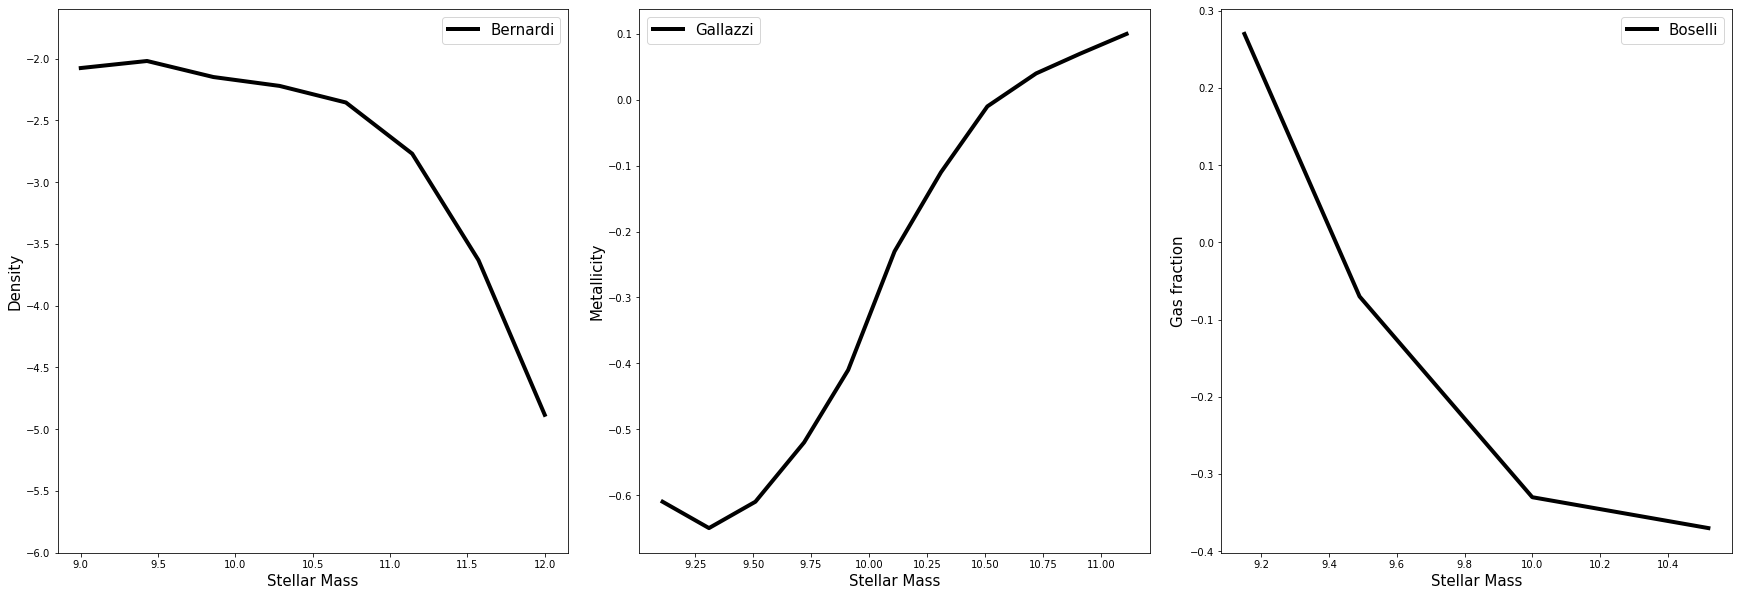

In [40]:
plt.rcParams['font.size'] = 15
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
X, Y = 3,1
fig, axes = generateAxesForMultiplePlots(shape=(X,Y),figsize=(30,10),
                                      hspace=0.02,wspace=0.14)
x = smf_obs[:,0]
axes[0].plot(x,np.log10(smf_obs[:,1]), c='k',label="Bernardi",lw=4)
axes[0].set_xlabel("Stellar Mass")
axes[0].set_ylabel("Density")
axes[0].legend()
axes[0].set_ylim(-6,-1.6)
x = smz_obs[:,0]
axes[1].plot(x,smz_obs[:,1], c='k',label="Gallazzi",lw=4)
axes[1].set_xlabel("Stellar Mass")
axes[1].set_ylabel("Metallicity")
axes[1].legend()
x = smgf_obs[:,0]
axes[2].plot(x,smgf_obs[:,1], c='k',label="Boselli",lw=4)
axes[2].legend()
axes[2].set_xlabel("Stellar Mass")
axes[2].set_ylabel("Gas fraction")
#plt.savefig("fiducial.png",dpi=200,bbox_inches='tight')

0.039148077


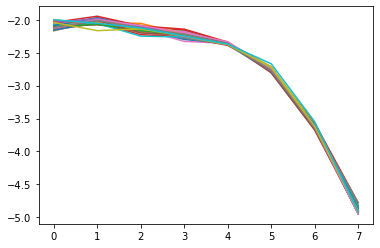

In [53]:
import torch
from torch.distributions.multivariate_normal import MultivariateNormal
from scipy.stats import ortho_group
dial =5e-3
dim  = smf_obs.shape[0]
mean = torch.tensor(np.log10(smf_obs[:,1]), dtype=torch.float)
O = ortho_group.rvs(dim=dim)
D = np.eye(dim)*np.random.random(size=dim)*dial
COV = np.matmul(O,np.matmul(D,O.T))
for i in range(dim):
    pass
    #COV[i,i] = 
detA = np.linalg.det(COV)
#mean = torch.zeros(dim)
covariance_matrix = torch.tensor(COV, dtype=torch.float)
N = MultivariateNormal(loc=mean,covariance_matrix=covariance_matrix)
samples3 = N.sample(sample_shape=([1000,])).cpu().detach().numpy()
for i in range(30):
    plt.plot(range(dim),samples3[i,:])
print(samples3.std(axis=0).mean(axis=0))
#plt.yscale("log")
np.save("../CalSAM/covariance/smf_fid", COV)

0.0158531


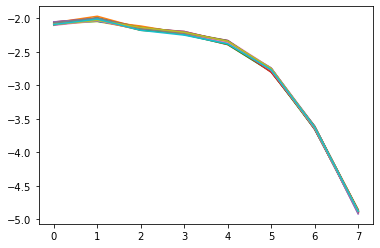

In [6]:
import torch
from torch.distributions.multivariate_normal import MultivariateNormal
from scipy.stats import ortho_group
dial =5e-4
dim  = smf_obs.shape[0]
mean = torch.tensor(np.log10(smf_obs[:,1]), dtype=torch.float)
O = ortho_group.rvs(dim=dim)
D = np.eye(dim)*np.random.random(size=dim)*dial
COV = np.matmul(O,np.matmul(D,O.T))
for i in range(dim):
    pass
    #COV[i,i] = 
detA = np.linalg.det(COV)
#mean = torch.zeros(dim)
covariance_matrix = torch.tensor(COV, dtype=torch.float)
N = MultivariateNormal(loc=mean,covariance_matrix=covariance_matrix)
samples3 = N.sample(sample_shape=([1000,])).cpu().detach().numpy()
for i in range(30):
    plt.plot(range(dim),samples3[i,:])
print(samples3.std(axis=0).mean(axis=0))
#plt.yscale("log")
np.save("../CalSAM/covariance/smf_small", COV)

0.08491594


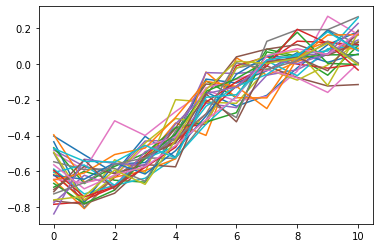

In [52]:
import torch
from torch.distributions.multivariate_normal import MultivariateNormal
from scipy.stats import ortho_group
dial =2e-2
dim  = smz_obs.shape[0]
mean = torch.tensor(smz_obs[:,1], dtype=torch.float)
O = ortho_group.rvs(dim=dim)
D = np.eye(dim)*np.random.random(size=dim)*dial
COV = np.matmul(O,np.matmul(D,O.T))
for i in range(dim):
    pass
    #COV[i,i] = 
detA = np.linalg.det(COV)
#mean = torch.zeros(dim)
covariance_matrix = torch.tensor(COV, dtype=torch.float)
N = MultivariateNormal(loc=mean,covariance_matrix=covariance_matrix)
samples3 = N.sample(sample_shape=([1000,])).cpu().detach().numpy()
for i in range(30):
    plt.plot(range(dim),samples3[i,:])
print(samples3.std(axis=0).mean(axis=0))
#plt.yscale("log")
np.save("../CalSAM/covariance/smz_fid", COV)

0.010747852


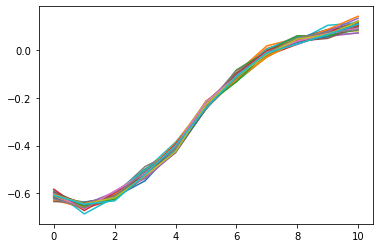

In [10]:
import torch
from torch.distributions.multivariate_normal import MultivariateNormal
from scipy.stats import ortho_group
dial =2e-4
dim  = smz_obs.shape[0]
mean = torch.tensor(smz_obs[:,1], dtype=torch.float)
O = ortho_group.rvs(dim=dim)
D = np.eye(dim)*np.random.random(size=dim)*dial
COV = np.matmul(O,np.matmul(D,O.T))
for i in range(dim):
    pass
    #COV[i,i] = 
detA = np.linalg.det(COV)
#mean = torch.zeros(dim)
covariance_matrix = torch.tensor(COV, dtype=torch.float)
N = MultivariateNormal(loc=mean,covariance_matrix=covariance_matrix)
samples3 = N.sample(sample_shape=([1000,])).cpu().detach().numpy()
for i in range(30):
    plt.plot(range(dim),samples3[i,:])
print(samples3.std(axis=0).mean(axis=0))
#plt.yscale("log")
np.save("../CalSAM/covariance/smz_small", COV)

0.16761754


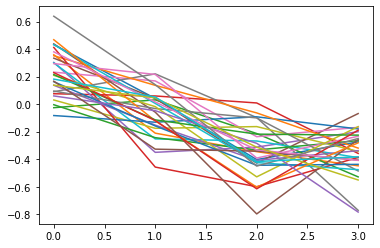

In [54]:
import torch
from torch.distributions.multivariate_normal import MultivariateNormal
from scipy.stats import ortho_group
dial =5e-2
dim  = smgf_obs.shape[0]
mean = torch.tensor(smgf_obs[:,1], dtype=torch.float)
O = ortho_group.rvs(dim=dim)
D = np.eye(dim)*np.random.random(size=dim)*dial
COV = np.matmul(O,np.matmul(D,O.T))
for i in range(dim):
    pass
    #COV[i,i] = 
detA = np.linalg.det(COV)
#mean = torch.zeros(dim)
covariance_matrix = torch.tensor(COV, dtype=torch.float)
N = MultivariateNormal(loc=mean,covariance_matrix=covariance_matrix)
samples3 = N.sample(sample_shape=([1000,])).cpu().detach().numpy()
for i in range(30):
    plt.plot(range(dim),samples3[i,:])
print(samples3.std(axis=0).mean(axis=0))
#plt.yscale("log")
np.save("../CalSAM/covariance/smgf_fid", COV)

0.014827436


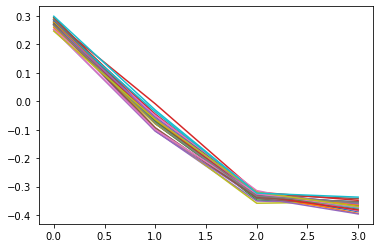

In [9]:
import torch
from torch.distributions.multivariate_normal import MultivariateNormal
from scipy.stats import ortho_group
dial =5e-4
dim  = smgf_obs.shape[0]
mean = torch.tensor(smgf_obs[:,1], dtype=torch.float)
O = ortho_group.rvs(dim=dim)
D = np.eye(dim)*np.random.random(size=dim)*dial
COV = np.matmul(O,np.matmul(D,O.T))
for i in range(dim):
    pass
    #COV[i,i] = 
detA = np.linalg.det(COV)
#mean = torch.zeros(dim)
covariance_matrix = torch.tensor(COV, dtype=torch.float)
N = MultivariateNormal(loc=mean,covariance_matrix=covariance_matrix)
samples3 = N.sample(sample_shape=([1000,])).cpu().detach().numpy()
for i in range(30):
    plt.plot(range(dim),samples3[i,:])
print(samples3.std(axis=0).mean(axis=0))
#plt.yscale("log")
np.save("../CalSAM/covariance/smgf_small", COV)